In [1]:
import os
import pathlib
import wget

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.dataset_tools import create_coco_tf_record as create_tf_record
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
model_path = 'C:/Users/david/Documents/code/OD-David'  

In [3]:
label_map_pbtxt_fname = 'C:/Users/david/Documents/code/OD-David/scada_label_map.pbtxt'

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
    (im_height, im_width, 3)).astype(np.uint8)

In [5]:
pipeline_file = model_path + '/pipeline_file.config'
model_dir = model_path + '/training/'

In [6]:

import pathlib

filenames = list(pathlib.Path(model_path + '/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)



[WindowsPath('C:/Users/david/Documents/code/OD-David/training/ckpt-1.index'), WindowsPath('C:/Users/david/Documents/code/OD-David/training/ckpt-2.index'), WindowsPath('C:/Users/david/Documents/code/OD-David/training/ckpt-3.index'), WindowsPath('C:/Users/david/Documents/code/OD-David/training/ckpt-4.index'), WindowsPath('C:/Users/david/Documents/code/OD-David/training/ckpt-5.index'), WindowsPath('C:/Users/david/Documents/code/OD-David/training/ckpt-6.index')]


In [7]:


#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)


INFO:tensorflow:Removing rpn_box_predictor_features from prediction_dict
INFO:tensorflow:Removing rpn_features_to_crop from prediction_dict
INFO:tensorflow:Removing feature_maps from prediction_dict


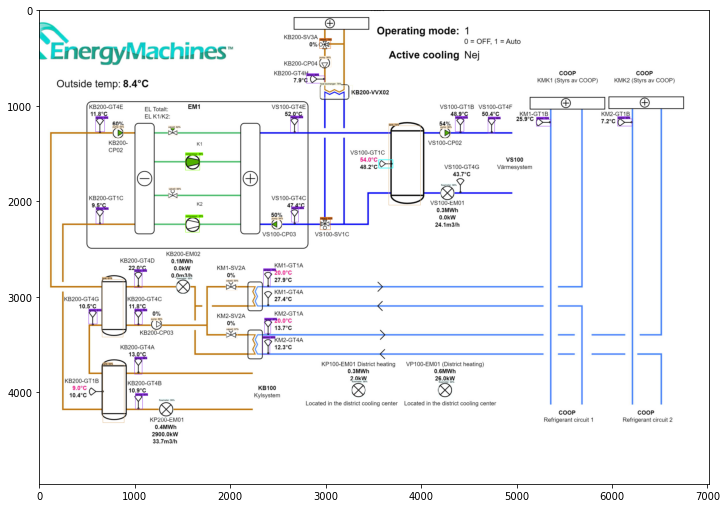

In [17]:


#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random
import glob
import cv2

#Opening select image dialog
#import easygui
#read_image = (easygui.fileopenbox())

#TEST_IMAGE_PATHS = ('C:/Users/david/Documents/code/OD-David/images_test/Kv_Duvholmen_EMHW.png')
TEST_IMAGE_PATHS = ('C:/Users/david/Documents/code/OD-David/images_test/MVG_Gallerian.png')
#TEST_IMAGE_PATHS = glob.glob('images_test/*.png')
#image_path = random.choice(TEST_IMAGE_PATHS)
image_path = TEST_IMAGE_PATHS
#image_np = load_image_into_numpy_array(image_path)
image_np = cv2.imread(image_path,3)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
      #line_thickness=12
)

plt.figure(figsize=(12, 16)) #12, 16
plt.imshow(image_np_with_detections)
plt.show()

In [18]:


# coordinates to build our HMI pages
boxes = detections['detection_boxes'].numpy()[0]
# get all boxes from an array
max_boxes_to_draw = boxes.shape[0]
# get scores to get a threshold
scores = detections['detection_scores'].numpy()[0]
# this is set as a default but feel free to adjust it to your needs
min_score_thresh=.5
# # iterate over all objects found
coordinates = []
for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    if scores[i] > min_score_thresh:
        class_id = int(detections['detection_classes'].numpy()[0][i] + 1)
        coordinates.append({
            "box": boxes[i],
            "class_name": category_index[class_id]["name"],
            "score": scores[i]
        })

"""(left, right, top, bottom) = (xmin * im_width, xmax * im_width, 
                              ymin * im_height, ymax * im_height)"""
print(coordinates)



[{'box': array([0.82533914, 0.17899354, 0.8608218 , 0.20054872], dtype=float32), 'class_name': 'flowmeter', 'score': 0.99117357}, {'box': array([0.7870973 , 0.5964328 , 0.81885487, 0.616766  ], dtype=float32), 'class_name': 'flowmeter', 'score': 0.99033934}, {'box': array([0.56852174, 0.20515533, 0.5986595 , 0.22578977], dtype=float32), 'class_name': 'flowmeter', 'score': 0.9855338}, {'box': array([0.7859624 , 0.46673426, 0.81809   , 0.48667422], dtype=float32), 'class_name': 'flowmeter', 'score': 0.98334694}, {'box': array([0.37158513, 0.59991366, 0.40249825, 0.6200786 ], dtype=float32), 'class_name': 'flowmeter', 'score': 0.9767685}, {'box': array([0.5523492 , 0.14233352, 0.58572996, 0.15400936], dtype=float32), 'class_name': 'sensor', 'score': 0.97197086}, {'box': array([0.6757324 , 0.27947417, 0.69360316, 0.2964042 ], dtype=float32), 'class_name': 'valve0', 'score': 0.9693721}, {'box': array([0.7369235 , 0.14258777, 0.76832384, 0.153987  ], dtype=float32), 'class_name': 'sensor', '

In [21]:
# deleting old file if exist
import os
if os.path.exists("filename.svg"):
    os.remove("filename.svg")
    print("The file has been deleted successfully")
else:
    print("The file does not exist!")

The file does not exist!


In [22]:
objet_dict = {
    "compressor" : "SCADALIBRARY#Compressor",
    "pump" : "SCADALIBRARY#Pump",
    "valve2" : "SCADALIBRARY#Valve 2Ports",
    "valve0" : "SCADALIBRARY#Valve Check",
    "flowmeter" : "SCADALIBRARY#Meter",
    "energy" : "SCADALIBRARY#Energy Meter",
    "heat exchanger" : "SCADALIBRARY#Heat Exchanger",
    "valve3" : "SCADALIBRARY#Valve 3Ports",
    'sensor' : "SCADALIBRARY#Sensor2",
    'tank' : 'SCADALIBRARY#Accumulator Tank'
}

In [23]:
# appendign objects on page
def appendObject(id, component, image_objects_x, image_objects_y):
    #image_objects_x = (image_objects_x*100)
    #image_objects_y = (image_objects_y*100)
    use = ET.SubElement(root, "use")
    #componentType = 'SCADALIBRARY#' + component
    componentType = (objet_dict[component])
    use.set(' xlink:href', componentType)
    id = id + 1
    uID = component + "-" + str(id)
    use.set('id', uID)
    use.set('data-auto-rotate-labels', 'false')
    use.set('x', image_objects_x)
    use.set('y', image_objects_y)
    use.set('width', '60')
    use.set('height', '60')

In [19]:
# creating svg page structure
import xml.etree.cElementTree as ET
root = ET.Element("svg")
# setting all root attributes
root.set('data-root', 'true')
root.set( 'xmlns', 'http://www.w3.org/2000/svg')
root.set('xmlns:xlink', 'http://www.w3.org/1999/xlink')
root.set('xmlns:xs', 'http://www.w3.org/2001/XMLSchema')

metadata = ET.SubElement(root, "metadata")
# metadata sub elements
ET.SubElement(metadata, "dependencies")
ET.SubElement(metadata, "groups")
ET.SubElement(metadata, "attachments")

localization = ET.SubElement(root, "localization")
ET.SubElement(localization, "dictionary")

for i in range(len(coordinates)):
    coordinate_x = (coordinates[i]['box'][1]) * (2024*(7016/4961))
    coordinate_y = (coordinates[i]['box'][0]) * (2024*(4961/7016))
    appendObject(i, coordinates[i]['class_name'], str(coordinate_x), str(coordinate_y))
    #appendObject(i, image_objects_raw[i]['class_name'], objects_coordinates[i][0], objects_coordinates[i][1])


tree = ET.ElementTree(root)

In [ ]:
try: 
    tree.write("filename3.svg")
    print("The page was created successfully")
except:
    print("Something went wrong")